# 方策勾配法による強化学習の例
方策勾配法に基づく強化学習アルゴリズムの例として、REINFORCE algorithmを紹介します。

In [1]:
# import文
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from environment import EnvSensor
from reward import Reward
from policy import PolicyGradient
from utils import stop_episode, plot_demo

## A. PolicyGradient classの紹介
`policy` moduleには、REINFORCE algorithmに基づく確率方策の方策勾配法を`PolicyGradient` classとして実装しています。このclassの使い方を紹介しましょう。

In [2]:
# instanceを建てる。
pol = PolicyGradient()

`PolicyGradient` classでは、確率方策としてsoftmax方策
\begin{eqnarray*}
\pi(a\mid s) &=& {\rm softmax}(\theta^T\phi_{s,a})
\end{eqnarray*}
を採用します。$\phi_{s,a}$はone-hot encodingで、$|S|\times|A|$次元のベクトルです。

**今回の場合** : 状態はbinningして17 categories, 行動は0/1の2種類あるので、今回34次元の状態行動ベクトル$\phi_{s,a}$とそれに対応する係数ベクトル$\theta$を準備しています。

この係数ベクトル$\theta$は、`PolicyGradient` classの`parameter_table`変数で確認することが出来ます。

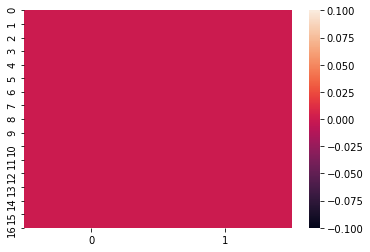

In [3]:
sns.heatmap(pol.parameter_table)
plt.show()

なお、確率方策として確認する場合は、`softmax`関数を適応すればよいです。（softmax方策だからです。）

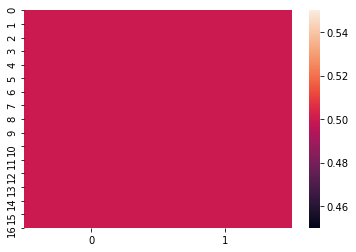

In [4]:
sns.heatmap(softmax(pol.parameter_table, axis = 1))
plt.show()

係数ベクトルの初期値は今回、すべてのセルで0の値にしています。ここは、何かしら事前分布として想定するものがあれば、それを初期値として構いません。確率方策なので、ある状態に対して行動は確率的に決定されます。`get_action(state)` methodを用いて、`state=*`の場合の行動を現状の方策に基づいて1つサンプリングすることが出来ます。

In [5]:
# state=130の場合に、初期方策で100回行動を決めた結果。
actions = []
for i in range(100):
    actions.append(pol.get_action(state = 130))
np.unique(actions, return_counts = True)

(array([0, 1]), array([46, 54], dtype=int64))

## B. REINFORCE alogrithmの例
さて、REINFORCE algorithmによって係数ベクトルを学習してみましょう。
* 学習するepisode数 : 10000回
* 1 episodeあたりのaction数 : 120回

とします。

In [6]:
n_episodes = 10000
n_actions = 120
env = EnvSensor()
rew = Reward()
pol = PolicyGradient()
reward_each_episode = []
cumulative_rewards = []

REINFORCE algorithmの学習は、episode単位（複数episodeでもよい）で実行されます。`fit(reward, gamma, learning_rate, end_of_episode, val)` methodでは、
* reward : 直前のactionに対する報酬を代入する。
* gamma : 最適化したい累積割引報酬の割引率（0<gamma<1）
* learning_rate : 各episodeでの学習率
* end_of_episode : 1 episodeが終了したかどうか。
* val : 未知episodeに対する累積報酬の計算（計算量が重くなるため普段はFalseでよい。）

を与えることで、REINFORCE algorithmによる係数ベクトルの学習を計算します。このうち**学習率**は極めて重要なハイパーパラメータです。学習率を適切に定めなければ、最適な累積割引報酬を得られるような方策に近づくことが出来ないので注意してください。また、**episode数（n_episode）**が少ない場合も、同様に最適な方策に十分に近づくことができません。

**演習** : いくつか学習率の候補を決め、以下のスクリプトで試してみてください。（元の結果を参照できるように、notebookをコピーして実験することをお勧めします。）

In [7]:
for i in tqdm(range(n_episodes)):
    state = env.reset()
    for j in range(1, n_actions+1):
        action = pol.get_action(state = state)
        state = env.get_state(action = action)
        reward = rew.get_reward(state = state)
        reward_each_episode.append(reward)    # rewardのログを保存
        if stop_episode(time = j) == 0:
            pol.fit(reward = reward, gamma = 1.0, learning_rate = 1.0/(i+1), 
                    end_of_episode = False, val = True)
        if stop_episode(time = j) == 1:
            pol.fit(reward = reward, gamma = 1.0, learning_rate = 1.0/(i+1), 
                    end_of_episode = True, val = True)
            cumulative_rewards.append(np.sum(reward_each_episode))    # episodeの累積報酬のログを取る。
            reward_each_episode = []    # rewardのログを初期化。
            break
print("End of all episodes")


End of all episodes


学習の結果を以下に可視化しました。特に右のグラフを見ると、stepが進むごとにgradientが徐々に小さくなってきていることが見て取れるでしょう。これは学習が収束しつつあることを意味しています。

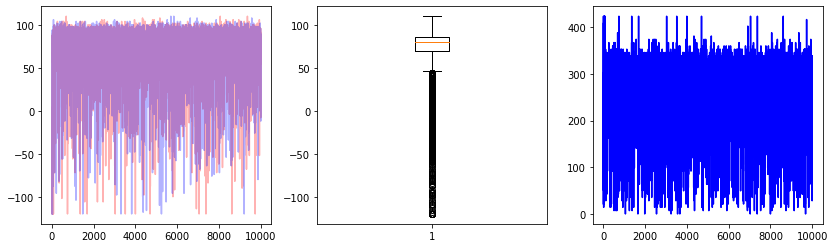

In [8]:
episode_index = [i for i in range(n_episodes)]
plt.figure(figsize = (14, 4))
plt.subplot(1, 3, 1)
plt.plot(episode_index, cumulative_rewards, color = "red", alpha = 0.3)
plt.plot(episode_index, pol.val_cumulative_rewards, color = "blue", alpha = 0.3)
plt.subplot(1, 3, 2)
plt.boxplot(pol.val_cumulative_rewards)
plt.subplot(1, 3, 3)
plt.plot(episode_index, pol.mean_absolute_gradient_history, color = "blue")
plt.show()

得られた確率方策によって、新しい環境で累積報酬・温度調整の成功回数をどれだけ得ることが出来るのか調べてみましょう。以下の結果を見てください。

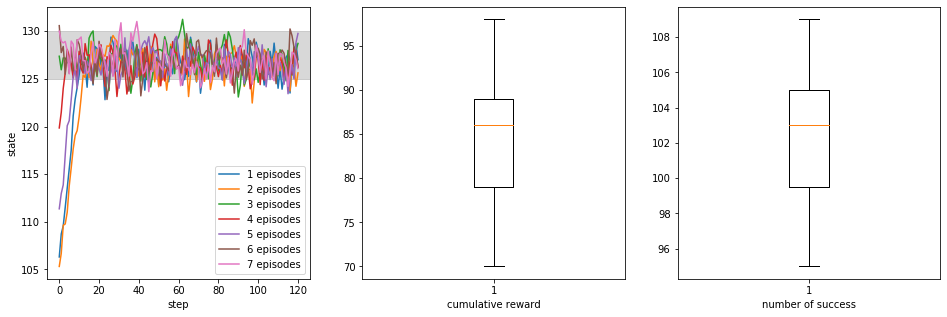

In [9]:
plot_demo(env = env, pol = pol, n_episodes = 7, steps_per_episode = 120)

学習後の方策も見てみましょう。これは`parameter_table`に`softmax`関数を適応すれば、観察することが出来ます。（softmax方策だからです。）上手く学習できていることが分かります。また、`fit_counter` 変数を用いて係数ベクトルが学習された回数を調べることが出来ます。これを可視化したものが右のグラフですが、どの係数ベクトルもある程度多く更新されたことが見て取れます。

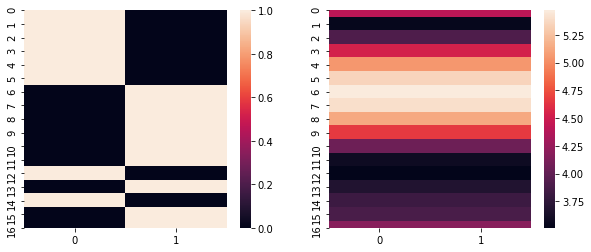

In [10]:
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(softmax(pol.parameter_table, axis = 1))
plt.subplot(1, 2, 2)
sns.heatmap(np.log10(pol.fit_counter+1))
plt.show()

## C. Remark
REINFORCE algorithmは、Robbins-Monro条件のもとで少なくとも局所最適解に収束することが知られています。一方で、Q-tableをsoftmax方策で学習するときのように、いったん決定方策にたどり着いてしまうと勾配が0になり、最適でない方策であっても学習が収束してしまうリスクがあるので注意しましょう。